<h1> Um die Funktionalität des Nootebooks zu gewährleisten, dürfen die Codezeilen NICHT Ausgeführt werden!</h1>
<h3>Codeblöcke am besten einfach mit einem doppelklick, (weit) <b>UNTERHALB</b> des "Playbuttons", einklappen </h3>

In [1]:
# 🧩 Zelle 1: Alle Importe
import psycopg2
import configparser
import os
import dis
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from mlxtend.frequent_patterns import apriori, association_rules
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose


print("Alle Imports geladen")

Alle Imports geladen


In [2]:
# 🔌 Verbindung zur PostgreSQL-Datenbank über .ini-Datei im Projekt-Hauptverzeichnis
def db_connect(config_file='../../config.ini', section='postgresql'):
    parser = configparser.ConfigParser()
    parser.read(config_file)

    if parser.has_section(section):
        db_params = {key: value for key, value in parser.items(section)}
    else:
        raise Exception(f"Sektion '{section}' nicht in '{config_file}' gefunden.")

    try:
        conn = psycopg2.connect(**db_params)
        print("✅ Verbindung zur Datenbank erfolgreich!")
        return conn
    except Exception as e:
        print("❌ Fehler bei der DB-Verbindung:", e)
        return None

# Verbindung aufbauen
conn = db_connect()


✅ Verbindung zur Datenbank erfolgreich!


### 📥 Datenabruf aus der Datenbank

In den oberen 2 Zelle importieren wir zunächst verschiedene Module, die wir für Visualisierungen und Berechnungen benötigen, bevor wir uns in Zelle 2 zu unserer Datenbank verbinden. Jetzt laden wir uns Datensätze aus unserer Datenbank in sogenannte **DataFrames**. Diese Tabellen bilden die Grundlage für alle weiteren Analysen und Visualisierungen.  

Hier ein kurzer Überblick, was in den jeweiligen Tabellen enthalten ist:

---

#### 📰 `df_landingpage` – Seitenaufrufe der Landingpage  
Diese Tabelle zeigt, **wie oft verschiedene Seiten** unserer Plattform an bestimmten Tagen **aufgerufen wurden**.

- `datum`: Der Tag des Aufrufs  
- `seitentitel`: Der Name der angezeigten Seite  
- `aufrufe`: Wie oft diese Seite an dem Tag aufgerufen wurde  

➡️ Damit analysieren wir, welche Seiten besonders häufig besucht wurden – z. B. ob bestimmte Inhalte stärker gefragt sind.

---

#### 📊 `df_user_behaviors` – Nutzerverhalten auf der Website  
Hier geht es darum, **wie sich Besucher auf der Seite verhalten** haben.

- `seitenaufrufe`: Gesamtzahl aller Seitenaufrufe  
- `nutzer_insgesamt`: Anzahl der einzelnen Besucher  
- `durchschn._zeit_auf_der_seite`: Wie lange sie im Durchschnitt geblieben sind  
- `absprungrate_in_prozent`: Anteil der Besucher, die nach nur einer Seite die Website verlassen haben  

➡️ Damit verstehen wir, **wie intensiv die Seite genutzt wurde** und wie gut sie Besucher halten kann.

---

#### 🎯 `df_what_did_user_do` – Nutzeraktionen und Ereignisse  
Diese Tabelle enthält **konkrete Aktionen oder Events**, die Nutzer ausgelöst haben – z. B. Klicks auf bestimmte Themen oder Funktionen.

- `name_des_events`: Art des Ereignisses (z. B. „Checked“, „Website“)  
- `event_label`: Zusätzliche Informationen zum Event (z. B. Thema „Coming Out“)  
- `aktive_nutzer`: Wie viele Nutzer dieses Event ausgelöst haben  
- `ereignisanzahl`: Wie oft das Event insgesamt stattgefunden hat  

➡️ Damit erkennen wir, **welche Inhalte oder Funktionen besonders häufig genutzt werden**.

---

#### 🌍 `df_where_did_they_come_from` – Herkunft der Besucher  
Diese Tabelle zeigt die **Traffic-Quellen**, also woher Besucher kamen.

- `quelle`: z. B. direkt , Google oder unbekannt  
- `sitzungen`: Wie viele Besuche über diese Quelle stattfanden  
- `aufrufe`: Gesamtzahl der Seitenaufrufe aus dieser Quelle  
- `aufrufe_pro_sitzung`: Durchschnittliche Seitenanzahl pro Besuch  

➡️ Das zeigt uns, **welche Kanäle besonders effektiv Nutzer auf die Seite bringen**.

---

#### 💻 `df_what_devices_used` – Genutzte Geräte  
Diese Tabelle zeigt, **welche Gerätetypen** (z. B. Desktop, Mobilgerät) genutzt wurden.

- `kategorie`: Art des Geräts  
- `wert`: Anzahl der Zugriffe mit diesem Gerät pro Tag  

➡️ Wir können erkennen, **ob unsere Seite eher mobil oder am PC genutzt wird**.

---

#### 🌱 `df_where_new_visitors_come_from` – Neue Besucher nach Quelle  
Hier sehen wir, **über welche Kanäle neue Nutzer** (also Erstbesucher) auf die Seite kamen.

- `kategorie`: Kanal (z. B. direkt, Suchmaschine, unbekannt)  
- `wert`: Anzahl neuer Besucher pro Tag und Kanal  

➡️ Wichtig für Marketing: **Welche Maßnahmen bringen neue Besucher auf die Website?**

---

#### 👥 `df_who_was_visiting` – Demografische Informationen  
Diese Tabelle zeigt **Informationen zur Zielgruppe**, z. B. Geschlecht oder andere demografische Merkmale.

- `kategorie`: z. B. „female“ (weiblich)  
- `wert`: Anzahl der Besucher in dieser Kategorie pro Tag  

➡️ Damit sehen wir, **welche Zielgruppen wir tatsächlich erreichen**.


In [3]:
# 📥 Zelle 3: Daten aus den DB-Tabellen in DataFrames laden
def load_table(name):
    return pd.read_sql(f'SELECT * FROM "{name}"', conn)


df_landingpage = load_table("landing_page_views")
df_user_behaviors = load_table("user_sessions")
df_what_did_user_do = load_table("user_events")
df_where_did_they_come_from = load_table("traffic_sources")
df_what_devices_used = load_table("device_usage")
df_where_new_visitors_come_from = load_table("traffic_source_chart")
df_who_was_visiting = load_table("daily_visitors_chart")

display("df_landingpage")
display(df_landingpage.head())
display("df_user_behaviors")
display(df_user_behaviors.head())
display("df_what_did_user_d")
display(df_what_did_user_do.head())
display("df_where_did_they_come_from")
display(df_where_did_they_come_from.head())
display("df_what_devices_used.")
display(df_what_devices_used.head())
display("df_where_new_visitors_come_from")
display(df_where_new_visitors_come_from.head())
display("df_who_was_visiting")
display(df_who_was_visiting.head())

'df_landingpage'

,datum,eid,seitentitel,aufrufe
0,2022-03-12,1,New Remix App,92
1,2022-03-12,2,Application Error!,1
2,2022-03-13,1,New Remix App,9
3,2022-03-14,1,New Remix App,609
4,2022-03-14,2,Application Error!,1


'df_user_behaviors'

,datum,seitenaufrufe,nutzer_insgesamt,durchschn._zeit_auf_der_seite,zeit_in_sekunden,seiten_/_sitzung,absprungrate_in_prozent
0,2022-03-12,93,2,00:01:11,71.0,46,50.0
1,2022-03-13,9,2,00:00:09,9.0,4,0.0
2,2022-03-14,610,3,00:06:29,389.0,67,0.0
3,2022-03-15,1,2,00:05:56,356.0,276,100.0
4,2022-03-16,114,2,00:01:33,93.0,57,100.0


'df_what_did_user_d'

,datum,eid,name_des_events,event_label,aktive_nutzer,ereignisanzahl
0,2023-09-28,1,Checked,(not set),3,22
1,2023-09-28,2,Website,(not set),2,4
2,2023-09-28,3,Checked,Coming Out,2,5
3,2023-09-28,4,Checked,Einsamkeit Überwinden,2,5
4,2023-09-28,5,Checked,Männlich,2,2


'df_where_did_they_come_from'

,datum,eid,quelle,sitzungen,aufrufe,aufrufe_pro_sitzung
0,2022-03-12,1,(direct),1,51,51
1,2022-03-12,2,(not set),1,42,42
2,2022-03-13,1,(direct),2,9,4
3,2022-03-14,1,(direct),9,610,67
4,2022-03-15,1,(not set),5,1,276


'df_what_devices_used.'

,datum,kategorie,wert
0,2022-03-12,desktop,93
1,2022-03-13,desktop,9
2,2022-03-14,desktop,610
3,2022-03-15,desktop,1
4,2022-03-16,desktop,114


'df_where_new_visitors_come_from'

,datum,kategorie,wert
0,2022-03-12,(direct),1
1,2022-03-12,(not set),1
2,2022-03-13,(direct),1
3,2022-03-14,(direct),2
4,2022-03-15,(not set),0


'df_who_was_visiting'

,datum,kategorie,wert
0,2023-01-12,female,15
1,2023-01-23,female,12
2,2023-01-31,female,11
3,2023-03-25,female,15
4,2023-03-27,female,11


## Überblick über die Daten und erste Analysen

Zunächst verschaffen wir uns einen Überblick über die Datentabellen. Der folgende Code gibt die Anzahl der Zeilen und Spalten für jede Tabelle aus. So sehen wir, mit welchen Datenmengen wir arbeiten. Die Daten umfassen unter anderem Informationen zur Startseite, zum Nutzerverhalten, zu den verwendeten Geräten und zur Herkunft der Besucher.

---

### Wer war auf der Seite? – Verteilung nach Geschlecht

Im ersten Diagramm wird dargestellt, wie viele Besucher welcher Geschlechtskategorie zugeordnet wurden.  
Die Daten stammen aus der Tabelle `df_who_was_visiting` und sind nach der Spalte `kategorie` (männlich/ weiblich) gruppiert. Die Werte in der Spalte `wert` geben die Anzahl der Personen pro Kategorie an.

Das Ergebnis ist ein Balkendiagramm, das zeigt, welche Kategorie am häufigsten vorkommt. Allerdings muss man erwähnen dass die Angaben hierzu freiwillig sind und auch nicht jeder Nutzer überhaupt eine Angabe zum Geschlecht gemacht hat. Durch eine zu geringe Anzahl an Daten zum Geschlecht, haben wir uns entschieden dieses bei unserern kommenden Analysen aussen vor zu lassen. 

---

### Mit welchen Geräten wurde die Seite besucht?

Hier betrachten wir die Gerätetypen, mit denen die Website besucht wurde.  
Die Tabelle `df_what_devices_used` wird nach `kategorie` (z. B. Smartphone, Desktop, Tablet) gruppiert, und die Werte aus der Spalte `wert` werden summiert.

Das Balkendiagramm gibt einen schnellen Eindruck davon, ob die Website eher mobil oder über Desktop-Geräte genutzt wird.

---

### Woher kamen die neuen Besucher? – Top 3 Kanäle

Für das Marketing ist interessant, aus welchen Quellen neue Besucher kommen.  
Die Tabelle `df_where_new_visitors_come_from` wird nach der Besuchsquelle (`kategorie`) gruppiert, und die Sitzungen (`wert`) werden gezählt. Anschließend werden die drei häufigsten Kanäle in einem Diagramm dargestellt.

So lässt sich erkennen, welche Kanäle am effektivsten neue Nutzer auf die Seite bringen (z. B. Google Ads, Social Media, Direktzugriffe).

---

### Was machen die Besucher auf der Website? – Top 5 Aktionen

Dieses Diagramm zeigt die fünf häufigsten Aktionen, die Nutzer auf der Website durchgeführt haben – etwa Klicks auf Buttons, das Abspielen von Medien oder das Absenden von Formularen.

Die Tabelle `df_what_did_user_do` enthält Eventnamen (`name_des_events`) und die Anzahl aktiver Nutzer (`aktive_nutzer`). Die Werte werden summiert, sortiert und als Balkendiagramm dargestellt.

So erkennen wir, welche Interaktionen besonders relevant sind.

---

### Gibt es Zusammenhänge zwischen den Nutzerzahlen? – Korrelationsanalyse

Abschließend visualisieren wir die Korrelationen zwischen verschiedenen Kennzahlen aus der Tabelle `df_user_behaviors`, z. B.:

- Seitenaufrufe  
- Anzahl Nutzer insgesamt  
- Absprungrate (Prozentsatz der Besucher, die die Seite sofort verlassen)  
- Verweildauer in Sekunden  
- Seiten pro Sitzung  

Eine Korrelation von +1 bedeutet, dass zwei Werte stark positiv zusammenhängen („je mehr A, desto mehr B“).  
Ein Wert von −1 bedeutet eine starke negative Beziehung („je mehr A, desto weniger B“).  
Ein Wert nahe 0 zeigt keinen klaren Zusammenhang.

Die Heatmap hilft dabei, Muster im Nutzerverhalten zu erkennen, etwa ob längere Verweildauer mit einer geringeren Absprungrate zusammenhängt.

---

## Auswertung der wichtigsten Kennzahlen

### Besucher nach Geschlecht

Die Mehrheit der Besucher ist weiblich (`female`) mit 7.060 Personen. Männliche Besucher (`male`) machen mit 1.505 einen deutlich kleineren Anteil aus. 
Das deutet darauf hin, dass die Website überwiegend von Frauen genutzt wird oder diese häufiger ihr Geschlecht angeben. Es kann aber auch einfach bedeuten das die User es aus Datenschutzgründen nicht angeben möchten um sich damit wohler zu fühlen.

---

### Besucher nach Gerätetyp

Die Zugriffe verteilen sich fast gleichmäßig auf Desktop (74.594) und mobile Geräte (71.715).  
Tablet (2.057) und Smart TV (7) spielen eine untergeordnete Rolle.  
Die Seite sollte also sowohl für Desktop als auch für mobile Nutzung optimiert sein.

---

### Top 3 Herkunftskanäle neuer Besucher

Die meisten neuen Besucher kommen über **Google** (29.487 Sitzungen).  
Direkte Zugriffe (`direct`) folgen mit 9.380 Sitzungen,  
gefolgt von `kompetenznetz-einsamkeit.de` mit 1.897 Sitzungen.  
Diese Kanäle sind somit besonders wichtig für den Website-Traffic.

---

### Top 5 Nutzeraktionen auf der Website

Die häufigsten Aktionen sind:  
- `Checked` mit 12.828 aktiven Nutzer,  
- `Website` mit 7.329,  
- `Email` mit 2.961,  
- `Phone` mit 1.137,  
- und `Image` mit 88 Nutzer.

Diese Daten zeigen, welche Interaktionen für die Besucher besonders relevant sind.

---

### Zusammenhänge zwischen Nutzerkennzahlen (Korrelationsmatrix)

- Seitenaufrufe und Absprungrate korrelieren negativ (−0,38): Mehr Seitenaufrufe gehen tendenziell mit einer geringeren Absprungrate einher.  
- Verweildauer (Sekunden) und Seiten pro Sitzung weisen eine moderate positive Korrelation (0,56) auf: Längere Sitzungen gehen mit mehr aufgerufenen Seiten einher.  
- Absprungrate und Verweildauer korrelieren leicht negativ (−0,20): Kürzere Verweildauer ist mit höherer Absprungrate verbunden.  
- Die Korrelationen zwischen „Nutzer insgesamt“ und anderen Kennzahlen sind eher schwach.

Diese Zusammenhänge helfen, das Nutzerverhalten besser zu verstehen und Optimierungspotenziale zu erkennen.


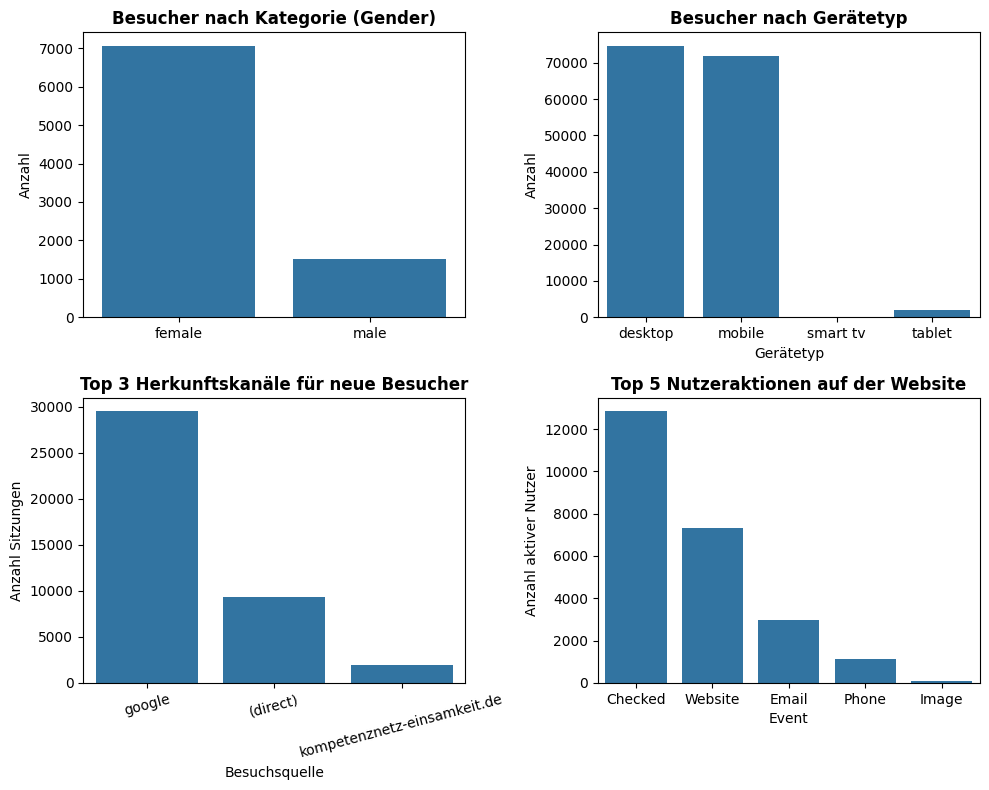

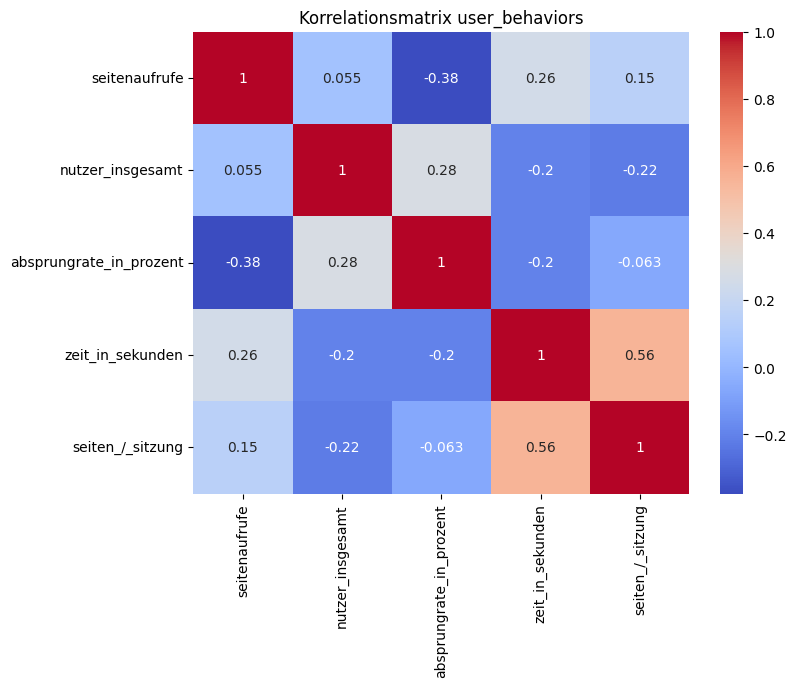

In [28]:
# #Überblick über Tabellen
# for name, df in [
#     ("Landingpage", df_landingpage),
#     ("User Behaviors", df_user_behaviors),
#     ("What Did User Do", df_what_did_user_do),
#     ("Where Did They Come From", df_where_did_they_come_from),
#     ("What Devices Used", df_what_devices_used),
#     ("Where New Visitors Come From", df_where_new_visitors_come_from),
#     ("Who Was Visiting", df_who_was_visiting),
# ]:
#     print(f"{name}: {df.shape}")


# Balkendiagramme in 2x2 Layout

fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 Zeilen, 2 Spalten

# 1. Besucher nach Kategorie (Gender)
data1 = df_who_was_visiting.groupby("kategorie")["wert"].sum().reset_index()
sns.barplot(data=data1, x="kategorie", y="wert", ax=axes[0, 0])
axes[0, 0].set_title("Besucher nach Kategorie (Gender)", fontweight="bold")
axes[0, 0].set_ylabel("Anzahl")
axes[0, 0].set_xlabel("")
# print("Besucher nach Kategorie")
# print(data1)

# 2. Besucher nach Gerätetyp
data2 = df_what_devices_used.groupby("kategorie")["wert"].sum().reset_index()
sns.barplot(data=data2, x="kategorie", y="wert", ax=axes[0, 1])
axes[0, 1].set_title("Besucher nach Gerätetyp", fontweight="bold")
axes[0, 1].set_ylabel("Anzahl")
axes[0, 1].set_xlabel("Gerätetyp")
# print("Besucher nach Gerätetyp")
# print(data2)

# 3. Top 3 Herkunftskanäle neuer Besucher
top_sources = (
    df_where_new_visitors_come_from.groupby("kategorie")["wert"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .reset_index()
)
sns.barplot(data=top_sources, x="kategorie", y="wert", ax=axes[1, 0])
axes[1, 0].set_title("Top 3 Herkunftskanäle für neue Besucher", fontweight="bold")
axes[1, 0].set_ylabel("Anzahl Sitzungen")
axes[1, 0].set_xlabel("Besuchsquelle")
axes[1, 0].tick_params(axis="x", rotation=15)
# print("Top 3 Herkunftskanäle neuer Besucher")
# print(top_sources)

# 4. Top 5 Nutzeraktionen
top_events = (
    df_what_did_user_do.groupby("name_des_events")["aktive_nutzer"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)
sns.barplot(data=top_events, x="name_des_events", y="aktive_nutzer", ax=axes[1, 1])
axes[1, 1].set_title("Top 5 Nutzeraktionen auf der Website", fontweight="bold")
axes[1, 1].set_ylabel("Anzahl aktiver Nutzer")
axes[1, 1].set_xlabel("Event")
axes[1, 1].tick_params(axis="x")

plt.tight_layout()
plt.show()
# print("Top 5 Nutzeraktionen")
# print(top_events)

# Korrelationsmatrix user_behaviors (numerisch)
num_cols = [
    "seitenaufrufe",
    "nutzer_insgesamt",
    "absprungrate_in_prozent",
    "zeit_in_sekunden",
    "seiten_/_sitzung",
]

plt.figure(figsize=(8, 6))
sns.heatmap(df_user_behaviors[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Korrelationsmatrix user_behaviors")
plt.show()

<h1>Aggregation der Verhaltensdaten pro Tag</h1>
<p>In diesem Codeblock fassen wir die Nutzerdaten aus der Tabelle <code>user_behaviors</code> auf Tagesbasis zusammen. Das bedeutet, wir berechnen für jeden einzelnen Tag folgende Kennzahlen:</p>
<ul>
  <li><strong>Seitenaufrufe:</strong> Die Gesamtzahl der aufgerufenen Seiten an diesem Tag.</li>
  <li><strong>Nutzer Insgesamt:</strong> Die Summe aller Nutzer, die an diesem Tag die Plattform genutzt haben.</li>
  <li><strong>Durchschnittliche Verweildauer:</strong> Die mittlere Zeit (in Sekunden), die Nutzer auf der Seite verbracht haben.</li>
  <li><strong>Durchschnittliche Absprungrate:</strong> Der durchschnittliche Anteil an Besuchern, die die Seite sofort wieder verlassen haben.</li>
  <li><strong>Seiten pro Sitzung:</strong> Die durchschnittliche Anzahl der Seiten, die ein Nutzer pro Besuch angeschaut hat.</li>
</ul>
<p>Durch diese Aggregation gewinnen wir eine kompakte Tagesübersicht, die es ermöglicht, Trends und Muster im Nutzerverhalten über die Zeit besser zu erkennen. Beispielsweise können wir so Tage mit besonders hohem Traffic oder mit besonders langer Verweildauer identifizieren.</p>

<h1>Was man sieht und was es bedeutet:</h1>
<ul>
  <li>Die Tabelle zeigt eine erste Zusammenfassung der wichtigsten Verhaltenskennzahlen pro Tag.</li>
  <li>Diese aggregierten Werte bilden die Grundlage, um zeitliche Veränderungen im Nutzerverhalten zu analysieren, wie z.B. ob es bestimmte Wochentage mit besonders vielen Besuchern gibt oder wie sich die Verweildauer über die Zeit verändert.</li>
  <li>Diese Informationen sind wichtig, um saisonale Effekte, Spitzenzeiten oder potenzielle Problemzeiten (z.B. hohe Absprungrate) zu erkennen und darauf reagieren zu können.</li>
</ul>


In [6]:
# Aggregation pro Tag: Seitenaufrufe & durchschnittliche Verweildauer

daily_agg = (
    df_user_behaviors.groupby("datum")
    .agg(
        {
            "seitenaufrufe": "sum",
            "nutzer_insgesamt": "sum",
            "zeit_in_sekunden": "mean",
            "absprungrate_in_prozent": "mean",
            "seiten_/_sitzung": "mean",
        }
    )
    .reset_index()
)

display(daily_agg.sort_values(by="datum", ascending=False))

,datum,seitenaufrufe,nutzer_insgesamt,zeit_in_sekunden,absprungrate_in_prozent,seiten_/_sitzung
1146,2025-07-01,59,54,67.0,70.69,1.0
1145,2025-06-30,88,71,79.0,42.70,0.0
1144,2025-06-29,89,60,124.0,27.54,1.0
1143,2025-06-28,81,72,60.0,40.51,1.0
1142,2025-06-27,70,62,57.0,39.71,1.0
...,...,...,...,...,...,...
4,2022-03-16,114,2,93.0,100.00,57.0
3,2022-03-15,1,2,356.0,100.00,276.0
2,2022-03-14,610,3,389.0,0.00,67.0
1,2022-03-13,9,2,9.0,0.00,4.0


<h1>Analyse der Zeitreihe: Trend, saisonale Muster und Rest bei Seitenaufrufen</h1>

<p>Mit diesem Code wird die Entwicklung der täglichen Seitenaufrufe über etwa ein Jahr untersucht. Dabei wird die Zeitreihe in mehrere Bestandteile zerlegt, um Muster besser zu verstehen:</p>

<h2>Was macht der Code genau?</h2>
<ul>
  <li><strong>Datenvorbereitung:</strong> Die täglichen Seitenaufrufe werden als Zeitreihe geordnet (Index ist das Datum). Fehlende Tage werden ergänzt, und fehlende Werte werden mit dem letzten bekannten Wert aufgefüllt.</li>
  <li><strong>Zerlegung (seasonal_decompose):</strong> Die Methode teilt die Daten in drei Teile auf:</li>
  <ul>
    <li><strong>Trend:</strong> Der langfristige Verlauf. Zeigt, ob die Seitenaufrufe im Mittel steigen, fallen oder stabil bleiben.</li>
    <li><strong>Saisonale Komponente:</strong> Wiederkehrende Schwankungen innerhalb eines Jahres (hier 365 Tage). Zum Beispiel höhere Aufrufe zu bestimmten Jahreszeiten oder Wochentagen.</li>
    <li><strong>Residual (Rest):</strong> Der Teil, der nicht durch Trend oder saisonale Muster erklärt wird – also zufällige Schwankungen oder Ausreißer.</li>
  </ul>
  <li><strong>Visualisierung:</strong> Die Grafik zeigt alle drei Teile als separate Linienplots, damit man sie gut vergleichen kann.</li>
</ul>

<h2>Was sieht man in der Grafik?</h2>
<ul>
  <li><strong>Originaldaten (obere Grafik):</strong> Die echten täglichen Seitenaufrufe.</li>
  <li><strong>Trend (zweite Grafik):</strong> Die geglättete Linie, die den allgemeinen Aufwärts- oder Abwärtstrend zeigt. Anfangs fehlen hier Werte, weil der Algorithmus erst genug Daten braucht, um den Trend zu berechnen.</li>
  <li><strong>Saisonale Komponente (dritte Grafik):</strong> Die regelmäßigen Schwankungen, die sich im Laufe eines Jahres wiederholen. Positive Werte zeigen Tage mit mehr Besuchern als der Trend erwartet, negative Werte Tage mit weniger Besuchern.</li>
  <li><strong>Residual / Rest (unterste Grafik):</strong> Die "Reste", also alles, was nicht durch Trend oder saisonale Muster erklärt wird. Hier sind die zufälligen Schwankungen und Ausreißer sichtbar.</li>
</ul>

<h2>Warum ist das wichtig?</h2>
<ul>
  <li><strong>Trend erkennen:</strong> Man sieht, ob die Webseite insgesamt mehr oder weniger besucht wird – eine wichtige Grundlage für Entscheidungen über Wachstum und Entwicklung.</li>
  <li><strong>Saisonale Muster verstehen:</strong> Man erkennt typische wiederkehrende Zeiten mit hoher oder niedriger Besucherzahl – etwa Feiertage, Wochenenden oder saisonale Einflüsse.</li>
  <li><strong>Rest analysieren:</strong> Hilft dabei, unerwartete Ereignisse (z.B. plötzliche Traffic-Spitzen) von normalen Mustern zu unterscheiden.</li>
  <li>Das alles hilft, die Webseite besser zu steuern, z.B. für Marketingaktionen, Serverplanung oder Nutzeranalysen.</li>
</ul>

<p>Zusammengefasst: Diese Zerlegung zeigt dir, wie sich deine Besucherzahlen über das Jahr verteilt entwickeln, welche regelmäßigen Muster es gibt und welche Schwankungen außergewöhnlich sind.</p>


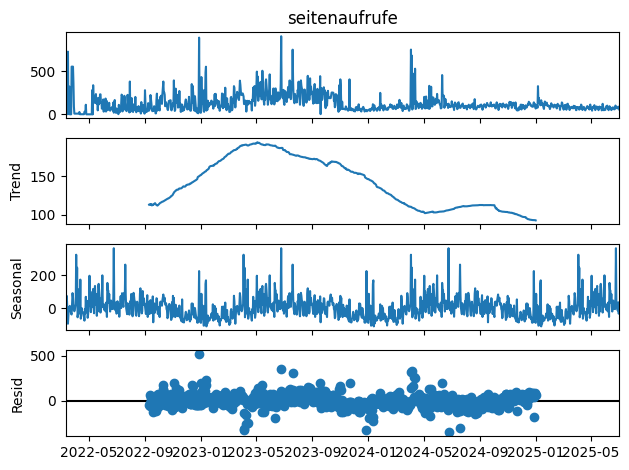

In [7]:
# Analyse der Zeitreihe
ts = (
    df_user_behaviors.set_index("datum")["seitenaufrufe"]
    .asfreq("D")
    .fillna(method="ffill")
)
res = seasonal_decompose(ts, model="additive", period=365)
res.plot()
plt.tight_layout()
plt.show()
# display(res.trend.head())
# display(res.seasonal.head())

<h1>Erkennung und Visualisierung von ungewöhnlichen Tagen bei Seitenaufrufen</h1>

<p>Dieser Code zeigt uns, an welchen Tagen die Seitenaufrufe auf der Website besonders ungewöhnlich waren – also Ausreißer-Tage, die sich stark von normalen Tagen unterscheiden.</p>

<h2>Was macht der Code genau?</h2>

<ol>
  <li><strong>Datenpunkte darstellen:</strong> Jeder Punkt im Diagramm steht für die Seitenaufrufe an einem bestimmten Tag.</li>
  <li><strong>Farbliche Unterscheidung:</strong> Normale Tage sind grünlich dargestellt, ungewöhnliche (Ausreißer) Tage rot.</li>
  <li><strong>Datum hervorheben:</strong> Über jedem Ausreißer-Punkt steht das genaue Datum. So erkennt man sofort, an welchem Tag dieser Ausreißer aufgetreten ist.</li>
  <li><strong>Leichte Versetzung:</strong> Das Datum wird etwas oberhalb des Punktes angezeigt, damit es nicht überlappt und gut lesbar bleibt.</li>
</ol>

<h2>Was sieht man im Ergebnis?</h2>

<ul>
  <li>Viele grünliche Punkte: Das sind ganz normale Tage mit üblichen Seitenaufrufen.</li>
  <li>Einige rote Punkte: Das sind die Ausreißer-Tage mit ungewöhnlich hohen oder niedrigen Seitenaufrufen.</li>
  <li>Zu jedem Ausreisser-Punkt sieht man das genaue Datum, so dass man schnell erkennt, wann die ungewöhnlichen Ereignisse stattgefunden haben.</li>
</ul>

<p>Diese Darstellung hilft dabei, besondere Tage mit auffälligen Besucherzahlen leicht zu erkennen und genau zuzuordnen.</p>


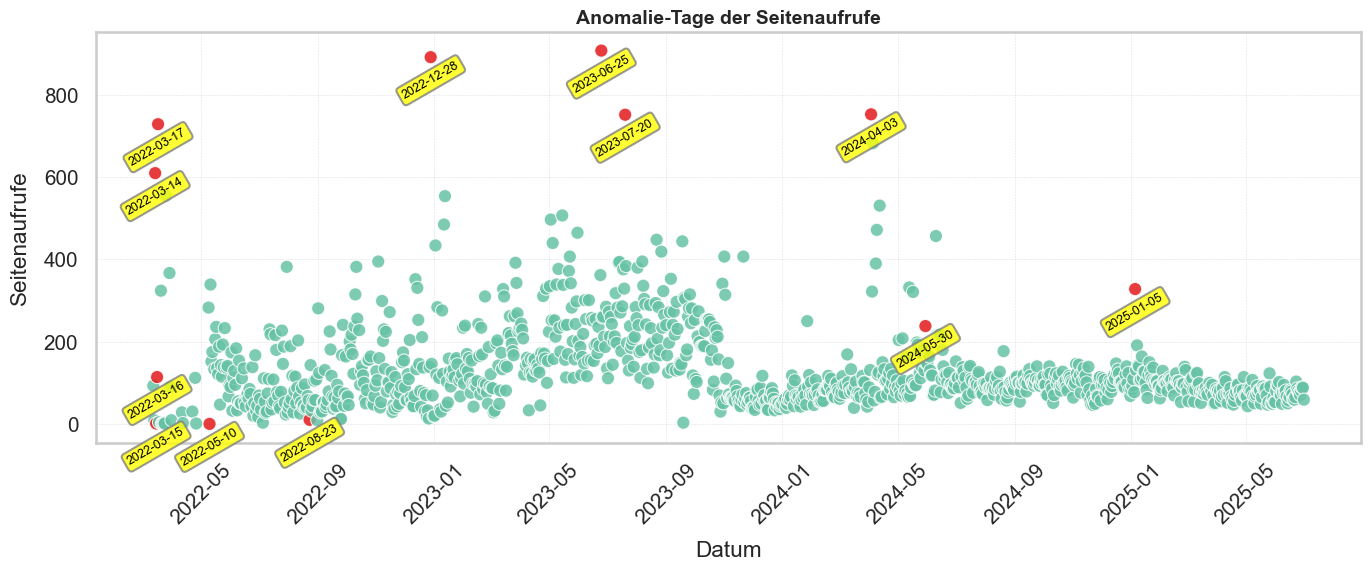

📋 **Anomalie-Tage und ihre auffälligen Kennzahlen:**

     datum  seitenaufrufe  nutzer_insgesamt absprungrate_in_prozent
2022-03-14            610                 3                    0.0%
2022-03-15              1                 2                  100.0%
2022-03-16            114                 2                  100.0%
2022-03-17            729                 2                  100.0%
2022-05-10              0                 1                  100.0%
2022-08-23             10                 6                  100.0%
2022-12-28            892                12                   10.5%
2023-06-25            908                29                    3.1%
2023-07-20            752               131                    4.8%
2024-04-03            753                88                   31.1%
2024-05-30            238               189                   28.8%
2025-01-05            328               272                   32.7%


In [ ]:
# Daten vorbereiten
daily = df_user_behaviors[
    ["datum", "seitenaufrufe", "nutzer_insgesamt", "absprungrate_in_prozent"]
].dropna()
daily["datum"] = pd.to_datetime(daily["datum"])
X_anom = daily[["seitenaufrufe", "nutzer_insgesamt", "absprungrate_in_prozent"]]

# Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42).fit(X_anom)
daily["anomaly"] = iso.predict(X_anom)

# Stil setzen
sns.set(style="whitegrid", context="talk", font_scale=0.9)
plt.figure(figsize=(14, 6))

# Plot zeichnen
palette = {1: "#66c2a5", -1: "#e31a1c"}  # türkis = normal, rot = Anomalie
sns.scatterplot(
    data=daily,
    x="datum",
    y="seitenaufrufe",
    hue="anomaly",
    palette=palette,
    legend=False,
    s=90,  # Punktgröße
    alpha=0.85,
)

# Labels unter Anomalie-Datenpunkten anzeigen
for _, row in daily[daily["anomaly"] == -1].iterrows():
    plt.text(
        row["datum"],
        row["seitenaufrufe"] - 100,  # x Einheiten unter dem Punkt
        row["datum"].strftime("%Y-%m-%d"),
        fontsize=9,
        color="black",
        ha="center",
        rotation=30,
        bbox=dict(
            facecolor="yellow", edgecolor="gray", boxstyle="round,pad=0.3", alpha=0.8
        ),
    )

# Achsen und Titel modernisieren
plt.title("Anomalie-Tage der Seitenaufrufe", fontsize=14, weight="bold")
plt.xlabel("Datum", labelpad=10)
plt.ylabel("Seitenaufrufe", labelpad=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, which="major", linestyle="--", linewidth=0.4, alpha=0.6)
plt.show()

# Tabelle mit Anomalie-Tagen
anomalies = daily[daily["anomaly"] == -1].copy()
anomalies = anomalies.sort_values("datum")

# Werte formatieren
anomalies["absprungrate_in_prozent"] = anomalies["absprungrate_in_prozent"].map(
    "{:.1f}%".format
)
anomalies["seitenaufrufe"] = anomalies["seitenaufrufe"].astype(int)
anomalies["nutzer_insgesamt"] = anomalies["nutzer_insgesamt"].astype(int)

# Ausgabe
display_columns = [
    "datum",
    "seitenaufrufe",
    "nutzer_insgesamt",
    "absprungrate_in_prozent",
]
print("📋 **Anomalie-Tage und ihre auffälligen Kennzahlen:**\n")
print(anomalies[display_columns].to_string(index=False))

## 📈 Entwicklung der wichtigsten Besuchergruppen über Zeit

Um langfristige Trends besser zu verstehen, betrachten wir die Daten **quartalsweise** – also aufgeteilt in 3-Monats-Zeiträume. Dabei analysieren wir:

- Die **Top 3 Besucherquellen**
- Die **Geschlechterverteilung**
- Die **verwendeten Geräte**

---

### 🔝 Top 3 Besucherquellen pro Quartal

Wir zeigen hier die **drei wichtigsten Traffic-Quellen** über die Zeit – also woher die Besucher kamen:

- **Direkt**: Nutzer geben die URL direkt ein oder haben ein Lesezeichen.
- **Organisch**: Nutzer kommen über Suchmaschinen (z. B. Google).
- **Referral**: Besucher kommen über andere Websites oder Links.

Die Linien zeigen, **wie sich diese Quellen über die Quartale entwickeln** – also ob z. B. Referral-Traffic steigt oder ob Direktzugriffe konstant bleiben.

---

### 🚻 Geschlechterverteilung pro Quartal

Hier betrachten wir, **wie viele weibliche und männliche Nutzer pro Quartal** aktiv waren.  
Ziel: Erkenntnisse darüber, ob bestimmte Kampagnen oder Inhalte **eher bei einem Geschlecht ankommen** oder ob die **Verteilung stabil** bleibt.

Tipp: Ein plötzlicher Ausschlag bei einem Geschlecht kann auf gezielte Inhalte oder Kanäle hindeuten, die besonders wirksam waren.

---

### 📱 Geräteverwendung pro Quartal

Welche Geräte verwenden die Besucher am häufigsten?

- **Mobile**: Smartphones, Tablets etc.
- **Desktop**: Laptops und PCs

Dieser Trend ist besonders spannend für die **UX-Optimierung**:  
Steigt der Mobile-Traffic stark an, sollten Landingpages und Interaktionen besonders **für mobile Endgeräte** optimiert werden.

---

### 🧠 Warum ist das wichtig?

- Langfristige Trends helfen, **strategische Entscheidungen zu treffen**.
- Verschiebungen im Verhalten (z. B. mehr Mobile, mehr weibliche Nutzer) deuten oft auf **Veränderungen im Zugang, in der Zielgruppe oder in der Wirkung von Maßnahmen** hin.
- Quartalsdaten sind robust genug, um saisonale Effekte zu erkennen, ohne sich im Tagesrauschen zu verlieren.

---



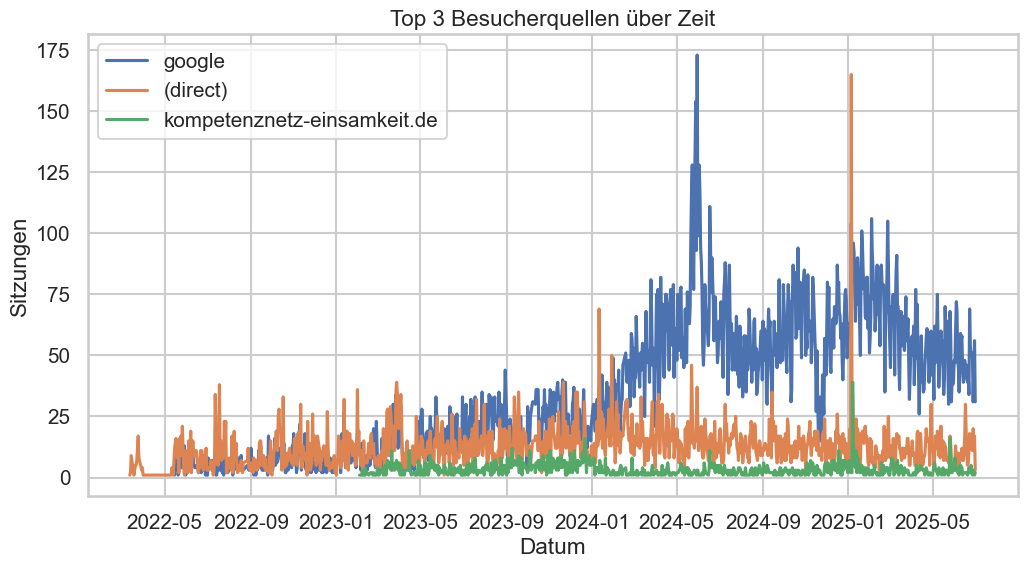

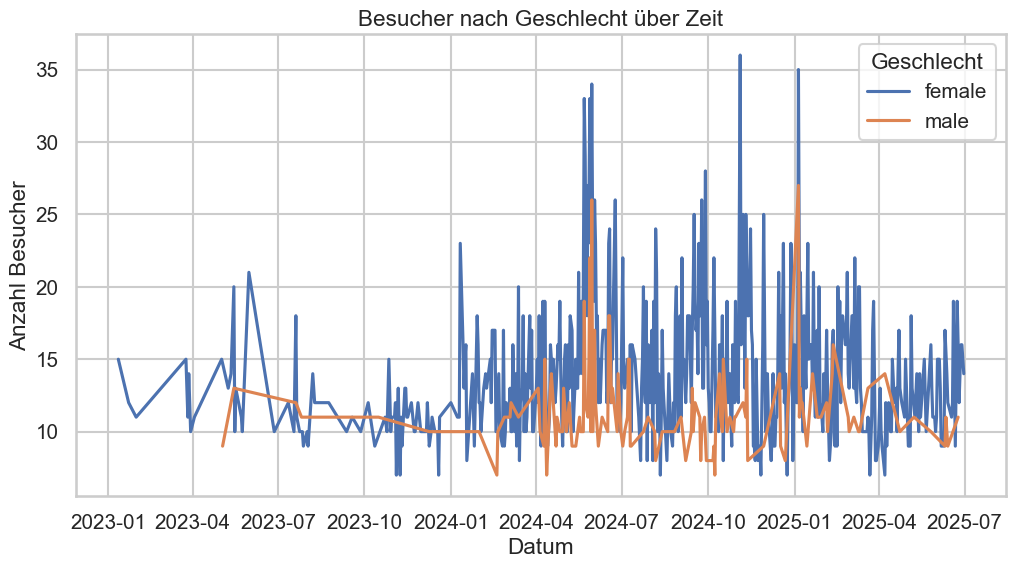

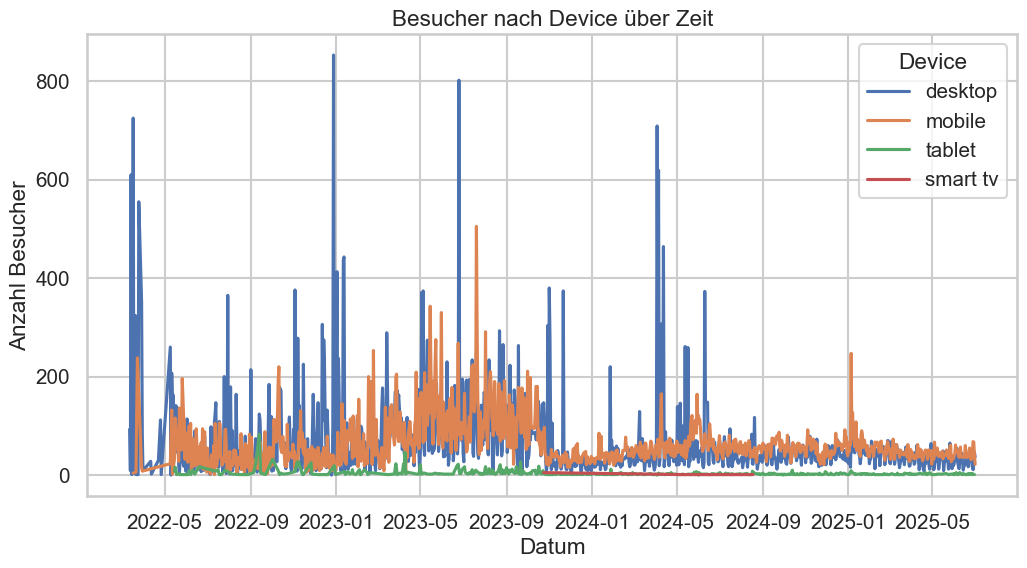

In [13]:
# Top 3 Besucherquellen über die Gesamtzeit
top_sources = (
    df_where_did_they_come_from.groupby("quelle")["sitzungen"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index
)

plt.figure(figsize=(12, 6))
for source in top_sources:
    subset = df_where_did_they_come_from[
        df_where_did_they_come_from["quelle"] == source
    ]
    subset_agg = subset.groupby("datum")["sitzungen"].sum().reset_index()
    sns.lineplot(data=subset_agg, x="datum", y="sitzungen", label=source)

plt.title("Top 3 Besucherquellen über Zeit")
plt.xlabel("Datum")
plt.ylabel("Sitzungen")
plt.legend()
plt.show()

# Geschlechter über Zeit plotten
df_gender = (
    df_who_was_visiting.groupby(["datum", "kategorie"])["wert"].sum().reset_index()
)

# Plot mit seaborn, x=datum, y=anzahl, hue=gender (für verschiedene Linien)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_gender, x="datum", y="wert", hue="kategorie")

plt.title("Besucher nach Geschlecht über Zeit")
plt.xlabel("Datum")
plt.ylabel("Anzahl Besucher")
plt.legend(title="Geschlecht")
plt.show()


# Devices über Zeit plotten
df_devices = (
    df_what_devices_used.groupby(["datum", "kategorie"])["wert"].sum().reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_devices, x="datum", y="wert", hue="kategorie")

plt.title("Besucher nach Device über Zeit")
plt.xlabel("Datum")
plt.ylabel("Anzahl Besucher")
plt.legend(title="Device")
plt.show()

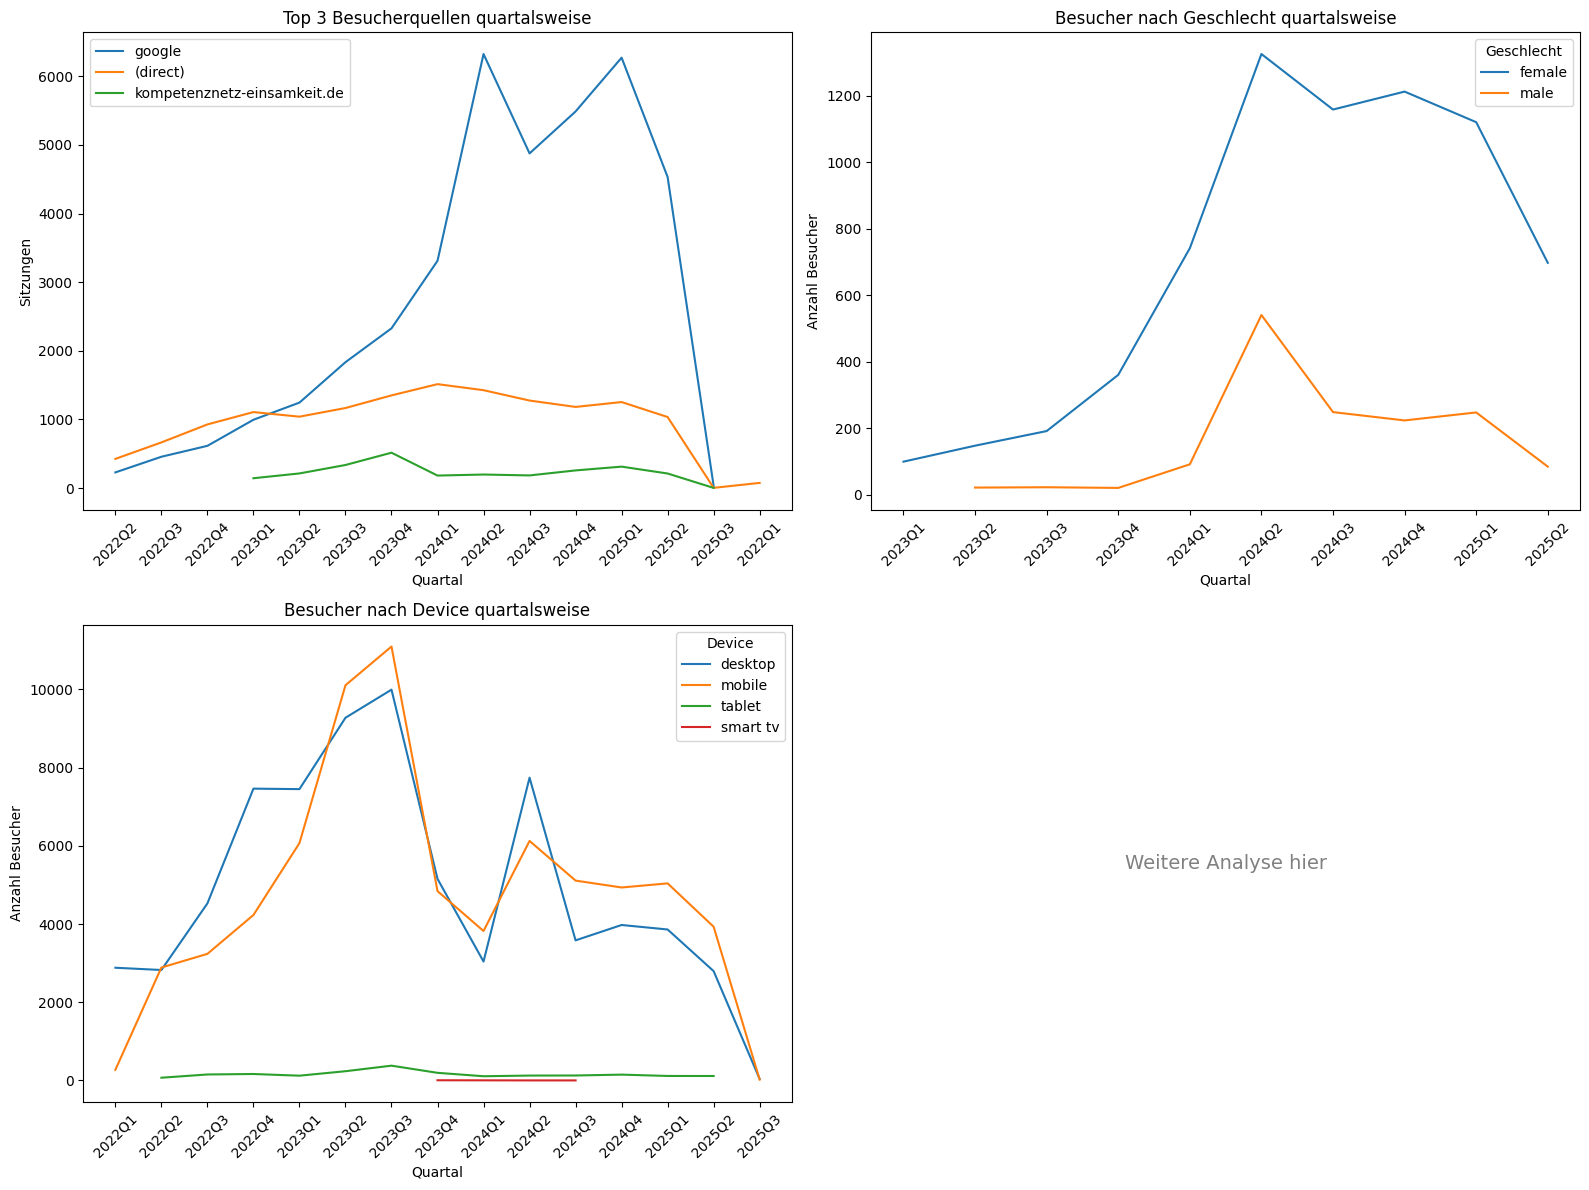

In [ ]:
# Top 3 Besucherquellen pro Quartal
def to_quarter(date_series):
    date_series = pd.to_datetime(date_series)
    return date_series.dt.to_period('Q').astype(str)

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 3 Besucherquellen
top_sources = (
    df_where_did_they_come_from.groupby("quelle")["sitzungen"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index
)

for source in top_sources:
    subset = df_where_did_they_come_from[df_where_did_they_come_from["quelle"] == source].copy()
    subset["quartal"] = to_quarter(subset["datum"])
    subset_agg = subset.groupby("quartal")["sitzungen"].sum().reset_index()
    sns.lineplot(data=subset_agg, x="quartal", y="sitzungen", label=source, ax=axs[0, 0])

axs[0, 0].set_title("Top 3 Besucherquellen quartalsweise")
axs[0, 0].set_xlabel("Quartal")
axs[0, 0].set_ylabel("Sitzungen")
axs[0, 0].legend()
axs[0, 0].tick_params(axis='x', rotation=45)

# 2. Geschlechter quartalsweise
df_gender = df_who_was_visiting.copy()
df_gender["quartal"] = to_quarter(df_gender["datum"])
df_gender_agg = df_gender.groupby(["quartal", "kategorie"])["wert"].sum().reset_index()

sns.lineplot(data=df_gender_agg, x="quartal", y="wert", hue="kategorie", ax=axs[0, 1])
axs[0, 1].set_title("Besucher nach Geschlecht quartalsweise")
axs[0, 1].set_xlabel("Quartal")
axs[0, 1].set_ylabel("Anzahl Besucher")
axs[0, 1].legend(title="Geschlecht")
axs[0, 1].tick_params(axis='x', rotation=45)

# 3. Devices quartalsweise
df_devices = df_what_devices_used.copy()
df_devices["quartal"] = to_quarter(df_devices["datum"])
df_devices_agg = df_devices.groupby(["quartal", "kategorie"])["wert"].sum().reset_index()

sns.lineplot(data=df_devices_agg, x="quartal", y="wert", hue="kategorie", ax=axs[1, 0])
axs[1, 0].set_title("Besucher nach Device quartalsweise")
axs[1, 0].set_xlabel("Quartal")
axs[1, 0].set_ylabel("Anzahl Besucher")
axs[1, 0].legend(title="Device")
axs[1, 0].tick_params(axis='x', rotation=45)

# 4. Leer lassen oder hier kannst du z.B. einen Text platzieren
axs[1, 1].axis('off')
axs[1, 1].text(0.5, 0.5, "Weitere Analyse hier", ha='center', va='center', fontsize=14, color='gray')

plt.tight_layout()
plt.show()


## 📊 Cluster-Analyse der Landingpages: Nutzungsintensität verstehen

Um die Nutzung der Landingpages besser einordnen zu können, haben wir die Seiten anhand ihrer **Aufrufhäufigkeit** mit einem Clustering-Verfahren gruppiert. Dabei wurde das Verfahren `KMeans` eingesetzt, wobei die optimale Anzahl der Cluster automatisch anhand des Silhouette-Scores bestimmt wurde.

Die ermittelte Clusteranzahl liegt je nach Datenlage zwischen zwei und sieben Gruppen. Für die verständliche Darstellung wurden die Cluster nach ihrem durchschnittlichen Aufrufvolumen sortiert und mit inhaltlichen Labels versehen. Dabei kamen bis zu drei Kategorien zur Anwendung:

* **Wenig aufgerufen**  
* **Durchschnittlich aufgerufen**  
* **Häufig aufgerufen**

In unserem Fall kommen nur 2 Labels zum Einsatzt, da nur 2 Cluster über den Silhouette-Score ermittelt wurden.

---

### 🏷️ Wie wurden die Labels vergeben?

Die Cluster-Labels basieren auf dem **Durchschnitt der Aufrufe innerhalb jedes Clusters**. Nach der Sortierung der Cluster-Mittelwerte wurden die drei wichtigsten Kategorien mit klaren Bezeichnungen versehen. Sollte die Clusteranzahl die Anzahl der Kategorien übersteigen, werden zusätzliche Cluster generisch benannt.

---

### 🔝 Top 15 Landingpages und ihre Nutzung

Für die Analyse wurden die 15 meistbesuchten Seiten betrachtet. Jede Seite wurde einem Cluster zugeordnet, um die Nutzungsintensität zu kategorisieren. Die genaue Verteilung der Seiten auf die Cluster hängt vom Ergebnis der Clusteranalyse ab und kann variieren.

---

### 📈 Warum ist das nützlich?

* Die **Cluster helfen dabei, Landingpages nach Nutzungsintensität zu gruppieren**, ohne dass man feste Schwellenwerte definieren muss.  
* So lassen sich beispielsweise Seiten mit **Optimierungspotenzial** oder solche mit **besonders hoher Sichtbarkeit** gezielt identifizieren.  
* Die farbige Visualisierung im Plot bietet einen schnellen Überblick über die Nutzungsstruktur der wichtigsten Seiten.


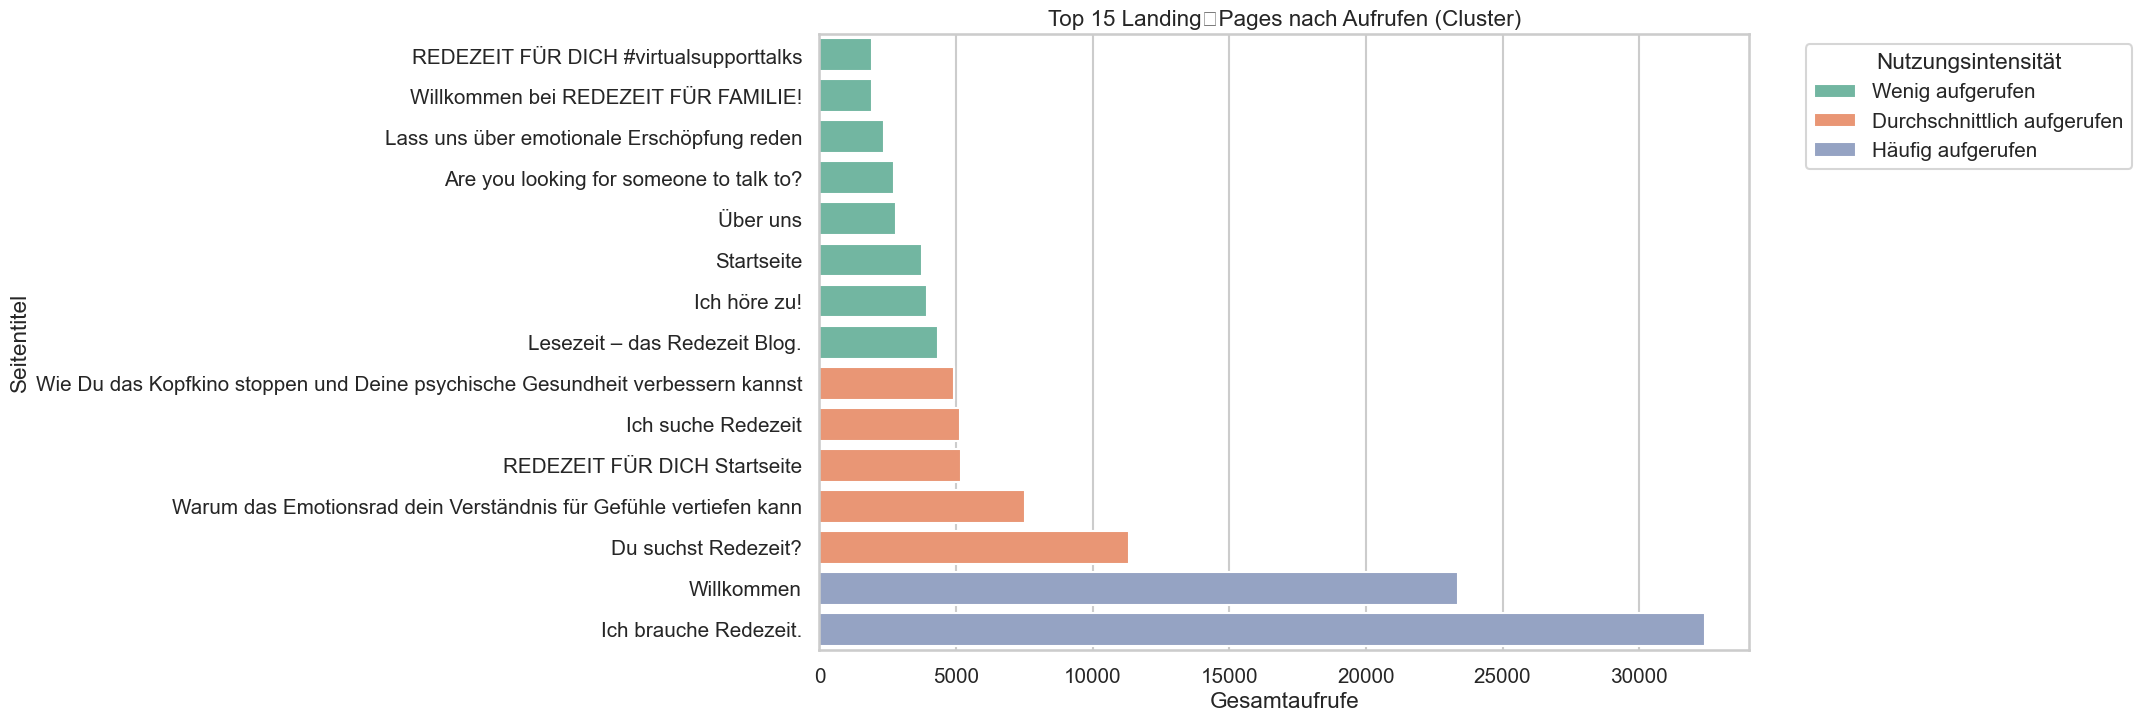

In [ ]:
# Erster Versuch mit 4 Fixen CLustern als vorgabe aber nur 3 in der Legende (old)

# Top 15 Landingpages auswählen
df_lp = df_landingpage.groupby("seitentitel")["aufrufe"].sum().reset_index()
df_lp = df_lp.sort_values("aufrufe", ascending=False).head(15).copy()

# Seitentitel mit Regex kürzen: nur Teil vor dem "|"
df_lp["seitentitel"] = df_lp["seitentitel"].str.replace(r"\s*\|.*$", "", regex=True)

# Clustering vorbereiten
scaler = StandardScaler()
X_lp = scaler.fit_transform(df_lp[["aufrufe"]])
kmeans_lp = KMeans(n_clusters=4, random_state=42).fit(X_lp)
df_lp["cluster"] = kmeans_lp.labels_

# Mittelwerte je Cluster berechnen (für sinnvolle Labels)
cluster_means = df_lp.groupby("cluster")["aufrufe"].mean().sort_values()

# Mapping von Cluster‐Index zu verständlichem Label
cluster_labels = {
    cluster_means.index[0]: "Wenig aufgerufen",
    cluster_means.index[1]: "Durchschnittlich aufgerufen",
    cluster_means.index[2]: "Häufig aufgerufen",
    cluster_means.index[3]: "Häufig aufgerufen",
    }

# Labels in DataFrame übernehmen
df_lp["cluster_label"] = df_lp["cluster"].map(cluster_labels)

# Nur die Top 15 Landingpages
top_lp = df_lp.sort_values("aufrufe", ascending=False).head(15)

# Plot mit beschrifteter Legende
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_lp.sort_values("aufrufe"),
    y="seitentitel",
    x="aufrufe",
    hue="cluster_label",
    palette="Set2",
)
plt.title("Top 15 Landing‑Pages nach Aufrufen (Cluster)")
plt.xlabel("Gesamtaufrufe")
plt.ylabel("Seitentitel")
plt.legend(title="Nutzungsintensität", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

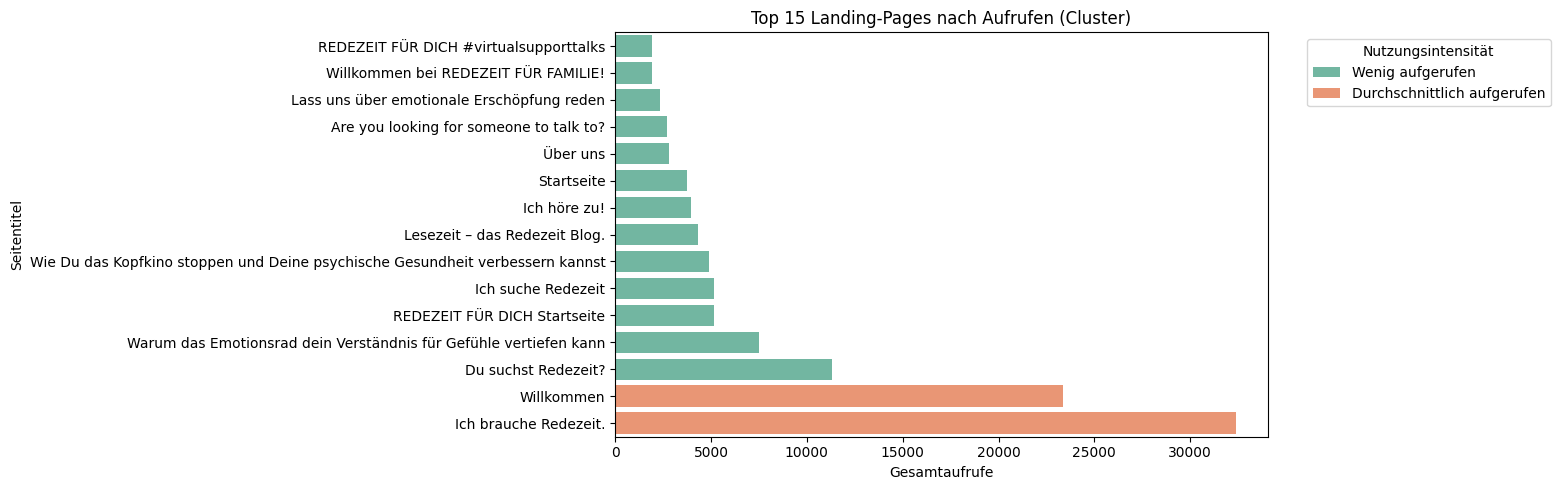

In [17]:
# Top 15 Landingpages auswählen
df_lp = df_landingpage.groupby("seitentitel")["aufrufe"].sum().reset_index()
df_lp = df_lp.sort_values("aufrufe", ascending=False).head(15).copy()

# Seitentitel mit Regex kürzen: nur Teil vor dem "|"
df_lp["seitentitel"] = df_lp["seitentitel"].str.replace(r"\s*\|.*$", "", regex=True)

# Clustering vorbereiten
scaler = StandardScaler()
X_lp = scaler.fit_transform(df_lp[["aufrufe"]])

# Optimale Clusteranzahl bestimmen
silhouette_scores = {}
for k in range(
    2, min(8, len(df_lp))
):  # sinnvoller Bereich 2 bis max 7 Cluster (max 15 Datenpunkte)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_lp)
    score = silhouette_score(X_lp, labels)
    silhouette_scores[k] = score

optimal_k = max(silhouette_scores, key=silhouette_scores.get)

# Clustering mit optimaler Anzahl k
kmeans_lp = KMeans(n_clusters=optimal_k, random_state=42, n_init="auto").fit(X_lp)
df_lp["cluster"] = kmeans_lp.labels_

# Cluster-Mittelwerte zur Sortierung
cluster_means = df_lp.groupby("cluster")["aufrufe"].mean().sort_values()

# Automatische Label-Zuweisung nach Mittelwert
cluster_labels = {}
labels = ["Wenig aufgerufen", "Durchschnittlich aufgerufen", "Häufig aufgerufen"]
for i, cluster in enumerate(cluster_means.index):
    label = labels[i] if i < len(labels) else f"Cluster {i}"
    cluster_labels[cluster] = label

# Labels übernehmen
df_lp["cluster_label"] = df_lp["cluster"].map(cluster_labels)

# Visualisierung
plt.figure(figsize=(16, 5))
sns.barplot(
    data=df_lp.sort_values("aufrufe"),
    y="seitentitel",
    x="aufrufe",
    hue="cluster_label",
    palette="Set2",
)
plt.title("Top 15 Landing‑Pages nach Aufrufen (Cluster)")
plt.xlabel("Gesamtaufrufe")
plt.ylabel("Seitentitel")
plt.legend(title="Nutzungsintensität", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()